# **FCA - UNICAMP**
**Disciplina: LE610 A - Sistemas Apoio à Decisão e ao Aprendizado Máquina**

Projeto 2: Escolha Investimento

Métodos: AHP-Promethee II & AHP-Topsis

In [ ]:
!pip install pymcdm
!pip install -U pymoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importando os pacotes do Python que serão utilizados
import numpy as np  # pacote numpy importado com o apelido de np
import cmath # pacote cmath faz operações com numeros complexos

from pymcdm import normalizations as norm, helpers, visuals
from pymcdm.methods import PROMETHEE_II, TOPSIS
from pymcdm.helpers import rrankdata, rankdata

from pymoo.mcdm.pseudo_weights import PseudoWeights
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.petal import Petal
from tabulate import tabulate
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
#Matriz de comparação par a par entre os critérios
C =  [[    1,    1,      3,       5,      1,      2,      1,      5],
      [    1,    1,      3,       5,      1,      2,      1,      5],
      [  1/3,  1/3,      1,     5/3,    1/3,    2/3,    1/3,    5/3],
      [  1/5,  1/5,    3/5,       1,    1/5,    2/5,    1/5,      1],
      [    1,    1,      3,       5,      1,      2,      1,      5],
      [  1/2,  1/2,    3/2,     5/2,    1/2,      1,    1/2,    5/2],
      [    1,    1,      3,       5,      1,      2,      1,      5],
      [  1/5,  1/5,    3/5,       1,    1/5,    2/5,    1/5,      1]] # matriz  

C #imprime a matriz para ver se ele ta sabendo

[[1, 1, 3, 5, 1, 2, 1, 5],
 [1, 1, 3, 5, 1, 2, 1, 5],
 [0.3333333333333333,
  0.3333333333333333,
  1,
  1.6666666666666667,
  0.3333333333333333,
  0.6666666666666666,
  0.3333333333333333,
  1.6666666666666667],
 [0.2, 0.2, 0.6, 1, 0.2, 0.4, 0.2, 1],
 [1, 1, 3, 5, 1, 2, 1, 5],
 [0.5, 0.5, 1.5, 2.5, 0.5, 1, 0.5, 2.5],
 [1, 1, 3, 5, 1, 2, 1, 5],
 [0.2, 0.2, 0.6, 1, 0.2, 0.4, 0.2, 1]]

In [ ]:
#Cálculo do autovalor e do autorvetor de C
autovalor, autovetor = np.linalg.eig(C)

#Considerar apenas a parte real do autovalor
autovalor_real = autovalor.real
autovetor = autovetor.real

#Encontrar o maior autovalor e sua posição
lambda_max = np.amax(autovalor_real) # maior autovalor
lambda_ind = np.argmax(autovalor_real) # posição do maior autovalor
print("O maior autovalor (lambda_max) é:", lambda_max)
print(" ")
print("Ele está na posição:", lambda_ind, "do vetor")

O maior autovalor (lambda_max) é: 8.000000000000002
 
Ele está na posição: 1 do vetor


In [ ]:
#Programando o método do autovalor como uma função
def ahp(C):
  autovalor, autovetor=np.linalg.eig(C)
  autovalor_real = autovalor.real
  autovetor = autovetor.real
  lambda_max = np.amax(autovalor_real) # maior autovalor
  lambda_ind=np.argmax(autovalor_real) # posição do maior autovalor
  vetor_P=autovetor[:, lambda_ind] #pega o autovalor correspondente a lambda_max
  vetor_P = vetor_P/sum(vetor_P) # w é o vetor de pesos normalizado
  RI_list = [0,0,0.58,0.90,1.12,1.24,1.32,1.41,1.45] # valores de RI pré-definidos
  n = len(C) # número de linhas de C
  CI = (lambda_max - n)/(n-1)
  RC = CI/RI_list[n-1]
  print("A razão de consistência é ", RC)
  print(" ")
  if RC <= 0.1:
    print("A matriz é consistente")
  else:
    print('\033[91m'+"Atenção:"+'\033[0m'+ "a matriz NÃO É consistente - revisar a comparação par-a-par.")
  print(" ")
  print("O vetor de prioridades é v:", vetor_P)
  print(" ")
  print("O maior autovalor é:", lambda_max)
  print(" ")

  return (vetor_P, lambda_max)

In [ ]:
vetor_P, lambda_max = ahp(C)

A razão de consistência é  1.799753636677052e-16
 
A matriz é consistente
 
O vetor de prioridades é v: [0.1910828  0.1910828  0.06369427 0.03821656 0.1910828  0.0955414
 0.1910828  0.03821656]
 
O maior autovalor é: 8.000000000000002
 


In [ ]:
criterios = ["Dividend Yield",	"Lucro Líquido (R$)",	"ROE",	"Dívida Líquida (R$)"	,"P/L",	"Liquidez Corrente",	"ROIC",	"Margem Líquida"]

In [ ]:
pesos_criterio = pd.DataFrame(criterios, columns = ["Critérios"])
pesos_criterio["Pesos"] = vetor_P
pesos_criterio = pesos_criterio.sort_values(["Pesos"], ascending=False)
pesos_criterio

,Critérios,Pesos
1,Lucro Líquido (R$),0.191083
0,Dividend Yield,0.191083
4,P/L,0.191083
6,ROIC,0.191083
5,Liquidez Corrente,0.095541
2,ROE,0.063694
3,Dívida Líquida (R$),0.038217
7,Margem Líquida,0.038217


In [ ]:
matrix = np.array([[7.07,	   30484000.00,  	12.74, 	     241.13,	   4.13,	 1.95,	10.29,	  18.29],
                   [4.83,	  917678000.00,  	 20.4, 	   54446.94,	   4.24,	 1.07,	 2.83,	  21.04],
                   [5.64,	  221060000.00,  	14.51, 	   26436.27,	   7.96,	 1.05,	 2.46,	  16.29],
                   [5.62,	  221060000.00,  	14.51, 	   26436.27,	   7.99,	 1.05,	 2.46,	  16.29],
                   [2.08,	   63274000.00,  	14.89, 	    5070.67,	   8.04,	 1.08,	 3.08,	  10.96],
                   [9.65,	 1124620000.00,  	15.27, 	   70152.81,	   8.07,	  1.1,	 2.35,	  15.45],
                   [9.59,	 1124620000.00,  	15.27, 	   70152.81,	   8.13,	  1.1,	 2.35,	  15.45],
                   [2.12,	   63274000.00,  	14.89, 	    5070.67,	    8.7,	 1.08,	 3.08,	  10.96],
                   [8.69,	 1124620000.00,  	15.27, 	   70152.81,	   9.12,	  1.1,	 2.35,	  15.45],
                   [5.56,	  429092000.00,  	11.22, 	   29063.26,	   9.37,	 1.12,	 1.86,	  52.24],
                   [4.42,	13839400000.00,  	14.64, 	  1317159.5,	  10.45,	 1.07,	 1.62,	  16.79],
                   [8.82,	 9522000000.00,  	18.89, 	   11063.00,	  10.57,	 5.98,	 0.48,	 188.87],
                   [7.84,	 9522000000.00,  	18.89, 	   11063.00,	   11.9,	 5.98,	 0.48,	 188.87],
                   [2.76,	20438700000.00,  	16.13, 	 1166171.24,	  12.55,	  1.1,	 1.87,	  10.07],
                   [4.58,	12746200000.00,  	 18.7, 	  612762.97,	  12.57,	 1.14,	 1.82,	  20.05],
                   [8.38,	22906600000.00,  	19.11,   1416015.00,	  12.59,	 1.09,	13.18,	  20.83],
                   [4.34,	12746200000.00,  	 18.7, 	  612762.97,	  12.67,	 1.14,	 1.82,	  20.05],
                   [4.04,	12746200000.00,  	 18.7, 	  612762.97,	  12.97,	 1.14,	 1.82,	  20.05],
                   [2.68,	20438700000.00,  	16.13, 	 1166171.24,	  14.22,	  1.1,	 1.87,	  10.07],
                   [7.26,	22906600000.00,  	19.11, 	 1416015.00,	  14.53,	 1.09,	13.18,	  20.83]], dtype = "float64")

# Define weights and types
weights = np.array(vetor_P)
types = np.array([  1, 1,  1, -1, -1,   1, 1,  1])

Alternativas = ["A1","A2","A3","A4","A5","A6","A7","A8","A9","A10","A11","A12","A13","A14","A15","A16","A17","A18","A19","A20"]

#Promethee II

In [ ]:
def promethee_I_visualization(Fp, Fm, legenda):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    ax.set_xlim(-0.51, 0.51)
    ax.set_ylim(-0.51, 0.51)
    ax.axis('off')

    ax.plot([0.5, 0.5], [-0.5, 0.5], 'k', linewidth=3)
    ax.plot([-0.5, -0.5], [-0.5, 0.5], 'k', linewidth=3)
    ax.plot([0, 0], [-0.5, 0.5], 'k',
            alpha=0.5, linewidth=1, linestyle='--')

    ax.text(-0.61, 0, 'Phi+', fontsize='large')
    ax.text(-0.56, 0.5, '1.0')
    ax.text(-0.56, -0.5, '0.0')

    ax.text(0.52, 0, 'Phi-', fontsize='large')
    ax.text(0.51, -0.5, '1.0')
    ax.text(0.51, 0.5, '0.0')

    for i, (fp, fm) in enumerate(zip(Fp, Fm)):
        ax.plot([-0.5, 0.5], [-0.5 + fp, 0.5 - fm], label = legenda[i] )
    plt.legend(loc = [1.2,0])


def promethee_II_vizualization(Fi, legenda):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    ax.set_xlim(-0.51, 0.51)
    ax.set_ylim(-0.51, 0.51)
    ax.axis('off')

    ax.plot([0, 0], [-0.5, 0.5], 'k', linewidth=5)
    ax.text(0.02, 0.5, '1.0')
    ax.text(0.02, 0, '0.0')
    ax.text(0.02, -0.5, '-1.0')

    for i in np.arange(-0.5, 0.51, 0.25):
        ax.plot([-0.02, 0.02], [i, i], 'k')
    

    for i, fi in enumerate(Fi):
        ax.plot([-0.1, 0.1], [fi/2, fi/2], label= legenda[i])
    plt.legend(loc = [1,0])

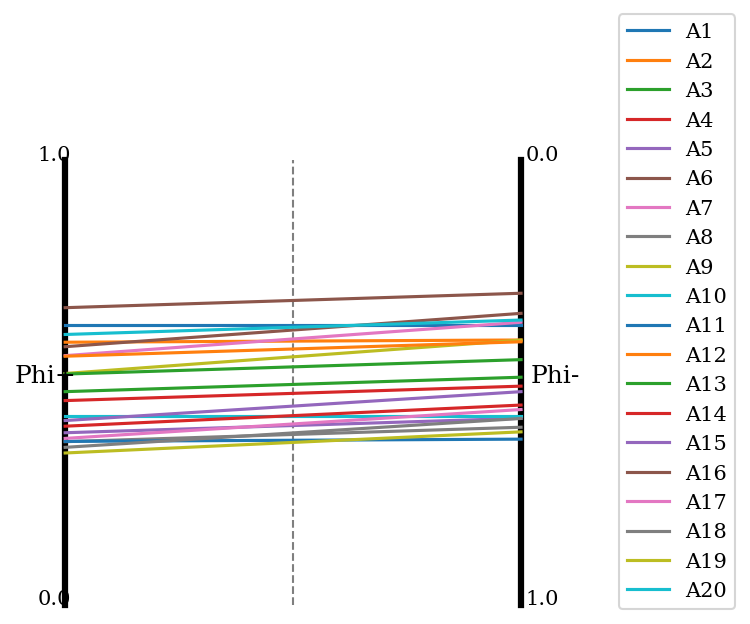

In [ ]:
#Promethee II - Fluxos Positivos e Negativos
promethee = PROMETHEE_II('usual')
Fp, Fm = promethee(matrix, weights, types, promethee_I = True)

promethee_I_visualization(Fp, Fm, Alternativas)

#Fluxos 
lista_de_tuplas = list(zip(Fp, Fm))
flows = pd.DataFrame(lista_de_tuplas, columns=["Fluxo Positivo", 'Fluxo Negativo'], index = Alternativas)
flows = flows.sort_values(['Fluxo Positivo'], ascending=False)

In [ ]:
flows.style.background_gradient(cmap = 'Blues')

,Fluxo Positivo,Fluxo Negativo
A16,0.668455,0.299028
A1,0.629903,0.370097
A20,0.608113,0.359370
A2,0.590681,0.404291
A6,0.580624,0.344284
A7,0.560510,0.364398
A12,0.559169,0.408314
A9,0.520282,0.404626
A13,0.518941,0.448542
A3,0.479383,0.488099


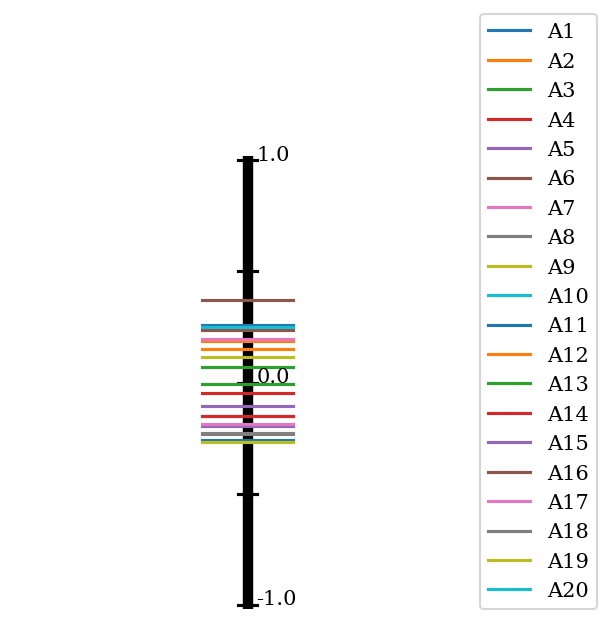

In [ ]:
#Promethee II - Fluxo Total 
promethee = PROMETHEE_II('usual')
Fi = promethee(matrix, weights, types)
promethee_II_vizualization(Fi, Alternativas)

distance = pd.DataFrame(Fi)

df = pd.DataFrame(Fi, index = Alternativas).rename({0: 'Fluxo Total'}, axis='columns').sort_values(['Fluxo Total'], ascending=False)

rank = []
for i in range(len(df)):
  rank.append(i+1)

df["Classificação"] = rank

In [ ]:
df.head(16)

,Fluxo Total,Classificação
A16,0.369427,1
A1,0.259806,2
A20,0.248743,3
A6,0.236339,4
A7,0.196111,5
A2,0.186390,6
A12,0.150855,7
A9,0.115655,8
A13,0.070399,9
A3,-0.008716,10


#TOPSIS

In [ ]:
topsis_methods = {
    'minmax': TOPSIS(norm.minmax_normalization),
}

results = {}
for name, function in topsis_methods.items():
    results[name] = function(matrix, weights, types)

df = pd.DataFrame(results, index = Alternativas).sort_values(["minmax"], ascending = [False])
df.style.highlight_max(color = "blue").set_precision(3)

<ipython-input-22-8697c5e8e357>:10: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df.style.highlight_max(color = "blue").set_precision(3)


,minmax
A16,0.625
A20,0.572
A1,0.545
A12,0.483
A6,0.456
A7,0.453
A13,0.441
A2,0.430
A9,0.416
A14,0.367


In [ ]:
results = {}
for name, function in topsis_methods.items():
    results[name] = rankdata(function(matrix, weights, types), reverse=True)

df = pd.DataFrame(results, index = Alternativas).sort_values(["minmax"], ascending = [True])
df.style.background_gradient(cmap='Blues').set_precision(0)

<ipython-input-24-c03408b3c723>:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df.style.background_gradient(cmap='Blues').set_precision(0)


,minmax
A16,1
A20,2
A1,3
A12,4
A6,5
A7,6
A13,7
A2,8
A9,9
A14,10
